In [3]:
import math, pickle, glob
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.linewidth'] = 0.8

saveformat = '.png' # or ''
dpi = 1200
paramtitle = False

In [4]:
workspace = 'noisy'
label = 'noisy_normal'
figlabel = pattern
wild_dir = './data/{}/'.format(pattern)

list_for_lpwise_dicts = []

path_list = glob.glob(wild_dir+'*.pickle')
for path in path_list:
    with open(path, 'rb') as f:
        hyperdict  = pickle.load(f)
        lpwise_dict = pickle.load(f)
    gammafloat = hyperdict['gamma']
    if math.isclose(gammafloat*10000 % 10, 5):
        gamma = '{:.4f}'.format(gammafloat)
    else:
        gamma = '{:.3f}'.format(gammafloat)
    list_for_lpwise_dicts.append((gamma, lpwise_dict))    
    
list_for_lpwise_dicts = sorted(list_for_lpwise_dicts, key=lambda x: float(x[0]) )

algo = hyperdict['algo']
T, T_save, loop, k, p = hyperdict['T'], hyperdict['T_save'] ,hyperdict['loop'], hyperdict['k'], hyperdict['p']
sigma, delta = hyperdict['sigma'], hyperdict['delta']
learning_param_list = np.asarray(hyperdict['lp_list'])
print(hyperdict)

NameError: name 'pattern' is not defined

In [59]:
#Gamma selection
allgamma = [float(x[0]) for x in list_for_lpwise_dicts]

#target = np.asarray([0.0, 0.006, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1]) * delta
target = np.asarray([0.0, 0.01, 0.02, 0.05]) * delta

targetidx = []
for idx, gamma in enumerate(allgamma):
    if np.any(np.isclose(gamma, target)):
        targetidx.append(idx)

list_for_lpwise_dicts = [list_for_lpwise_dicts[idx] for idx in targetidx]
        
print([float(x[0]) for x in list_for_lpwise_dicts])

[0.0, 0.01, 0.02, 0.05]


## Convergence Graph

0.01
100 0.00626037577977742
200 0.00498267422234306
600 0.005518006934063329


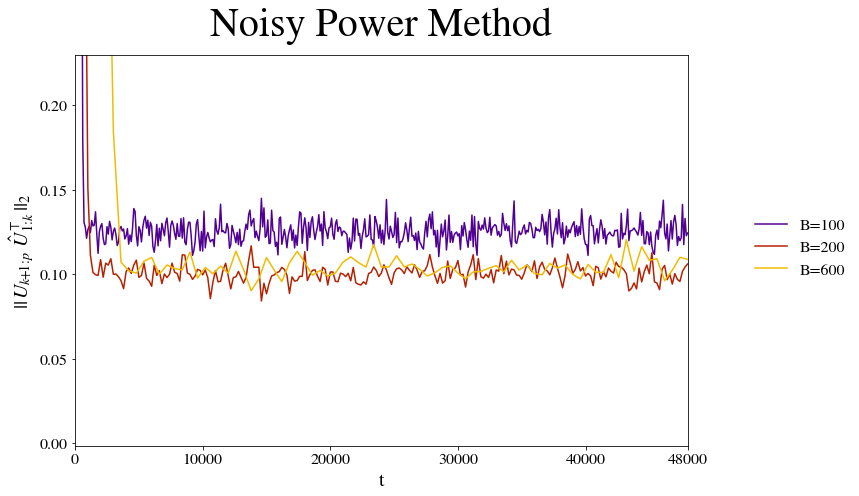

In [60]:
nnn = 1
smoothing = False
smoothing_str = '' if smoothing else '_nosmooth'

datadict_list = list_for_lpwise_dicts[nnn][1]
gamma = float(list_for_lpwise_dicts[nnn][0])
print(gamma)
fig = plt.figure(figsize=(12,7),facecolor=(1, 1, 1))

if algo == 'oja':
    titlestr = 'Oja\'s Algorithm'
    #_learning_param_list = learning_param_list[(learning_param_list<1/99) & (learning_param_list>1/1001)]
    _learning_param_list = learning_param_list[[5,4,2]]
    colors = pl.cm.gnuplot(np.linspace(0.1,0.9,len(_learning_param_list)))
else:
    titlestr = 'Noisy Power Method'
    #_learning_param_list = learning_param_list[(learning_param_list>99) & (learning_param_list<1001)]
    _learning_param_list = learning_param_list[[11,13,16]]
    colors = pl.cm.gnuplot(np.linspace(0.1,0.9,len(_learning_param_list)))

if paramtitle:
    title = titlestr +  r', $(\delta,\,\sigma,\,p/k,\,\Gamma)$'+r'$=({:.1f},\,{:.2f},\,{:d},\,{:.3f})$'.format(delta, sigma, p//k, gamma)
    titlesize = 28
else:
    title = titlestr
    titlesize = 40
plt.title(title,fontsize=titlesize,pad=20)
    
for c, lp in enumerate(_learning_param_list):
    
    grid = T_save if algo=='oja' else lp
    x = np.arange(T//grid + 1) * grid
    y = 0
    for datadict in datadict_list:
        yhat = datadict[lp]
        y += np.asarray(yhat)
        break
        
    #y /= loop
    
    if len(y) > 24 and smoothing:
        N =  3
        yconv = np.convolve(y, np.ones(N)/N, mode='valid')
        y[(N-1)//2:-(N-1)//2] = yconv
    
    if algo == 'oja':
        plt.plot(x,y, linewidth=1.5, color=colors[c],label=r'$\eta$={:.3e}'.format(lp))
    else:
        plt.plot(x,y, linewidth=1.5, color=colors[c],label='B={}'.format(lp))
        
    print(lp,np.std(y[len(y)//4:]))

plt.xlim(1,T)
plt.ylim(-0.002,0.23)

plt.xlabel('t',fontsize=20,labelpad=5)
plt.ylabel(r'$||\,U_{k\!\!+\!\!1\!:\!p}\,\,{\hat{U}_{1\!:\!k}^{\,\top}}\,||_2$',fontsize=20)
plt.xticks([0,10000,20000,30000,40000,48000],fontsize=16)
plt.yticks(fontsize=16)

fig.legend(loc="center right",fontsize=16,frameon=False,ncol=1)
plt.tight_layout()
fig.subplots_adjust(right=0.80) 
plt.savefig('./figs/'+figlabel+'_series'+smoothing_str+saveformat,dpi=dpi)

## Oja's Algorithm

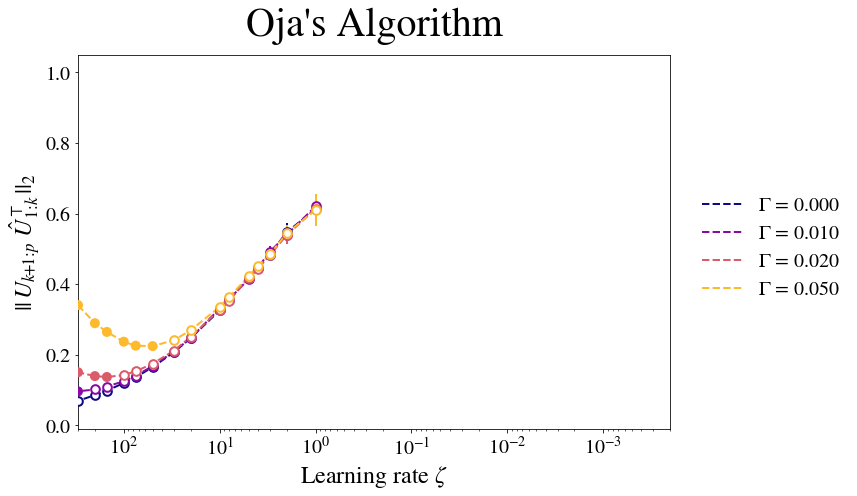

In [40]:
colors = pl.cm.plasma(np.linspace(0,0.85,len(list_for_lpwise_dicts)))
fig = plt.figure(figsize=(12,8),facecolor=(1, 1, 1))

for c, (label_str, datadict_list) in enumerate(list_for_lpwise_dicts):

    dist_array = np.zeros((loop,len(learning_param_list)))
    
    for idx,datadict in enumerate(datadict_list):

        for jdx,zeta in enumerate(learning_param_list):
            dist_array[idx,jdx] = np.average(datadict[zeta][-5:])

    avg = np.average(dist_array,axis=0)
    std = np.std(dist_array,axis=0)
    plt.plot(learning_param_list,avg,ls='--',linewidth=2,color=colors[c],label=r'$\Gamma$ = '+label_str,zorder=1)
    plt.errorbar(learning_param_list,avg,std,fmt='none', ecolor=colors[c],elinewidth=2,capsize=0,zorder=2)
    
    signlist = np.ones(len(learning_param_list))
    arg = np.argmin(avg)
    signlist[:arg] = -1
    for jdx, sign in enumerate(signlist):
        marker_s = ('o',100) if sign==1 else ('o',75)
        color_s   = ('none',colors[c]) if sign==1 else (colors[c],'white')
        plt.scatter(learning_param_list[jdx],avg[jdx],marker=marker_s[0],s=marker_s[1],color=color_s[1],edgecolors=color_s[0],linewidths=2,zorder=3)   

if paramtitle:
    title = 'Oja\'s Algorithm'+r', $(\delta,\,\sigma,\,p/k)=({:.1f},\,{:.2f},\,{:d})$'.format(delta, sigma, p//k)
    titlesize = 28
else:
    title = 'Oja\'s Algorithm'
    titlesize = 40
plt.title(title,fontsize=titlesize,pad=20)
        
plt.xlim(2.0e-4,300.0)
plt.ylim(-0.01,1.05)
plt.gca().invert_xaxis()
plt.xlabel(r'Learning rate $\zeta$',fontsize=24,labelpad=5)
plt.ylabel(r'$||\,U_{k\!\!+\!\!1\!:\!p}\,\,{\hat{U}_{1\!:\!k}^{\,\top}}\,||_2$',fontsize=24)
plt.xscale("log")
plt.xticks([1.0e-3,1.0e-2,1.0e-1,1.0,10.0,100.0],fontsize=20)
plt.yticks(fontsize=20)

fig.legend(loc="center right",fontsize=20,frameon=False,ncol=1)
plt.tight_layout()
fig.subplots_adjust(right=0.78)
plt.savefig('./figs/'+figlabel+saveformat,dpi=dpi)

## Noisy Power Method

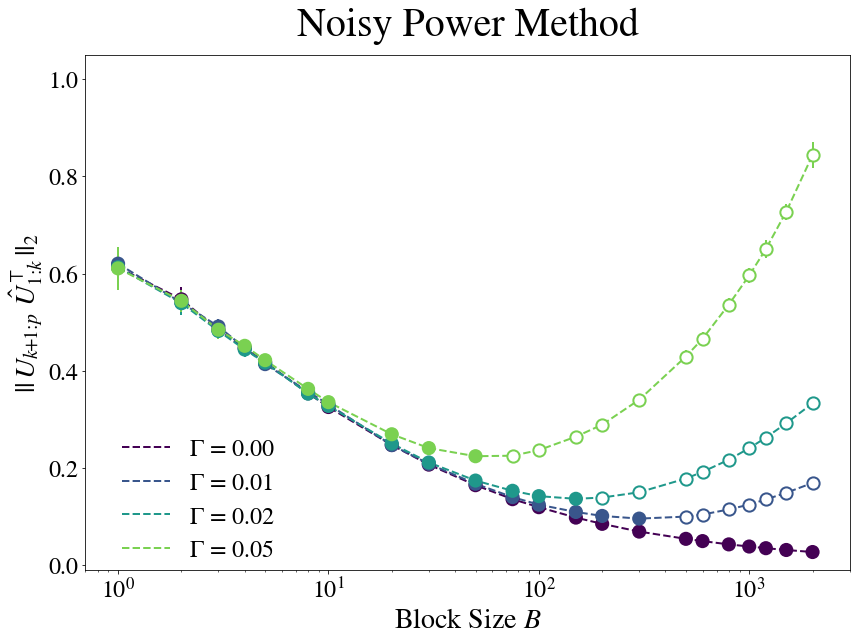

In [59]:
colors = pl.cm.viridis(np.linspace(0,0.8,len(list_for_lpwise_dicts)))
fig = plt.figure(figsize=(12,9),facecolor=(1, 1, 1))

for c, (label_str, datadict_list) in enumerate(list_for_lpwise_dicts):

    dist_array = np.zeros((loop,len(learning_param_list)))
    
    for idx,datadict in enumerate(datadict_list):

        for jdx,B in enumerate(learning_param_list):
            dist_array[idx,jdx] = np.average(datadict[B][-5:])

    avg = np.average(dist_array,axis=0)
    std = np.std(dist_array,axis=0)
    plt.plot(learning_param_list,avg,ls='--',linewidth=2,color=colors[c],label=r'$\Gamma$ = '+'{:.2f}'.format(float(label_str)),zorder=1)
    plt.errorbar(learning_param_list,avg,std,fmt='none', ecolor=colors[c],elinewidth=2,capsize=0,zorder=2)
    
    signlist = np.ones(len(learning_param_list))
    arg = np.argmin(avg)
    signlist[arg+1:] = -1
    for jdx, sign in enumerate(signlist):
        marker_s = ('o',200) if sign==1 else ('o',150)
        color_s   = ('none',colors[c]) if sign==1 else (colors[c],'white')
        plt.scatter(learning_param_list[jdx],avg[jdx],marker=marker_s[0],s=marker_s[1],color=color_s[1],edgecolors=color_s[0],linewidths=2,zorder=3) 

if paramtitle:
    title = 'Noisy Power Method'+r', $(\delta,\,\sigma,\,p/k)=({:.1f},\,{:.2f},\,{:d})$'.format(delta, sigma, p//k)
    titlesize = 28
else:
    title = 'Noisy Power Method'
    titlesize = 40
plt.title(title,fontsize=titlesize,pad=20)
        
plt.xlim(0.7,3000.0)
plt.ylim(-0.01,1.05)
plt.xlabel(r'Block Size $B$',fontsize=28,labelpad=5)
plt.ylabel(r'$||\,U_{k\!\!+\!\!1\!:\!p}\,\,{\hat{U}_{1\!:\!k}^{\,\top}}\,||_2$',fontsize=28)
plt.xscale("log")
plt.xticks([1,10,100,1000],fontsize=24)
plt.yticks(fontsize=24)

fig.legend(loc="upper left",bbox_to_anchor=(0.12,0.35), fontsize=24,frameon=False,ncol=1)
plt.tight_layout()
#fig.legend(loc="center right",fontsize=20,frameon=False,ncol=1)
#plt.tight_layout()
#fig.subplots_adjust(right=0.78)
plt.savefig('./figs/'+figlabel+saveformat,dpi=dpi)

## Consecutive Distance

[ 661.  100.   89.  106.  139.  124.  164.  163.  177.  215.  237.  267.
  248.  299.  316.  330.  366.  389.  484.  416.  488.  489.  529.  577.
  626.  623.  693.  722.  817.  866.  925. 1029. 1046. 1063. 1152. 1211.
 1267. 1313. 1437. 1456. 1563. 1622. 1777. 1836. 1906. 1995. 2122. 2181.
 2369. 7010.]
[3.26711039e-16 4.00000000e-03 8.00000000e-03 1.20000000e-02
 1.60000000e-02 2.00000000e-02 2.40000000e-02 2.80000000e-02
 3.20000000e-02 3.60000000e-02 4.00000000e-02 4.40000000e-02
 4.80000000e-02 5.20000000e-02 5.60000000e-02 6.00000000e-02
 6.40000000e-02 6.80000000e-02 7.20000000e-02 7.60000000e-02
 8.00000000e-02 8.40000000e-02 8.80000000e-02 9.20000000e-02
 9.60000000e-02 1.00000000e-01 1.04000000e-01 1.08000000e-01
 1.12000000e-01 1.16000000e-01 1.20000000e-01 1.24000000e-01
 1.28000000e-01 1.32000000e-01 1.36000000e-01 1.40000000e-01
 1.44000000e-01 1.48000000e-01 1.52000000e-01 1.56000000e-01
 1.60000000e-01 1.64000000e-01 1.68000000e-01 1.72000000e-01
 1.76000000e-01 1.80000

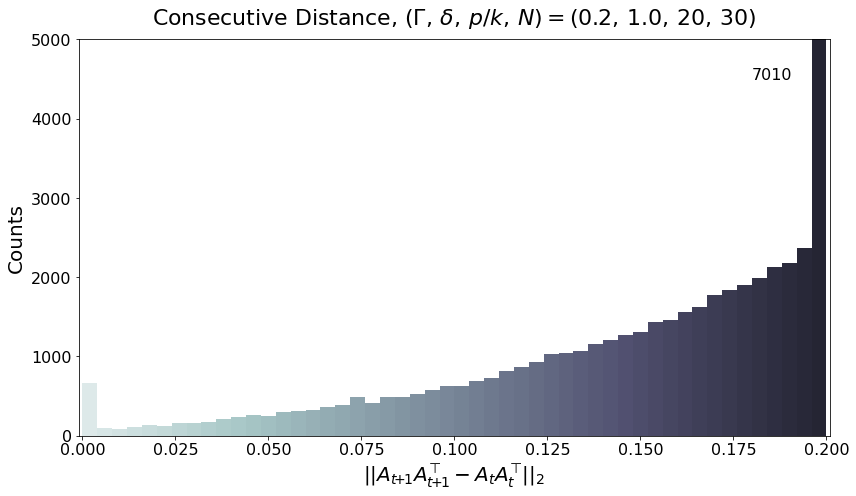

In [245]:
dist_load = np.load('./data/dists.npy')

fig = plt.figure(figsize=(12,7),facecolor=(1, 1, 1))

title = r'Consecutive Distance, $(\Gamma,\,\delta,\,p/k,\,N)=({:.1f},\,{:.1f},\,{:d},\,{:d})$'.format(0.2, delta, p//k, 30)
#plt.scatter(range(len(dist_load)),dist_load,marker='.',s=2.5,c='k')
n, bins, patches = plt.hist(dist_load,bins=50,color='grey',rwidth=1.01)

cm = plt.cm.bone
for i, patch in enumerate(patches):
    plt.setp(patch, 'facecolor', cm(0.15 + 0.75/50 * (50-i) ))
    
print(n)
print(bins)
    
plt.xlim(-0.001,0.201)
plt.ylim(0,5000)
plt.text(0.18,4500,'7010',fontsize=16)
plt.xlabel(r'$||{A_{t\!\!+\!\!1}}{A_{t\!\!+\!\!1}^{\top}} - {A_{t}}{A_{t}^{\top}}||_2$',fontsize=20)
plt.ylabel('Counts',fontsize=20,labelpad=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(title,fontsize=22,pad=15)

plt.tight_layout()
plt.savefig('./figs/'+'consecutive_distance'+saveformat,dpi=dpi)

# E.O.D